# Multi-Class SVM

This exercise guides you through the process of classifying images using Support Vector Machines(SVM). As part of this you will:

- Implement a fully vectorized loss function and for the SVM
- Calculate the analytical gradient using vectorized code
- Perform Stochastic Gradient Descent (SGD) to minimize the loss function
- Validate to tune the hyper-parameters
- Visualize the learned weights

In [12]:
# start-up code to import data-sets
from f15ece6504.get_cifar10 import load_CIFAR10
# loading some necessary packages
import numpy as np
import random
import matplotlib.pyplot as plt

# This is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading and Pre-processing CIFAR-10

Before proceeding, go to `hw0/f15ece6504/data/` and run the script `.get_datasets.sh` to download the CIFAR-10 data. 

In [2]:
# Assuming you have downloaded the CIFAR-10 database in your hw0/f15ece6504/f15ece6504/data folder, 
# we proceed to load the data into python
cifar10_dir = 'f15ece6504/data/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


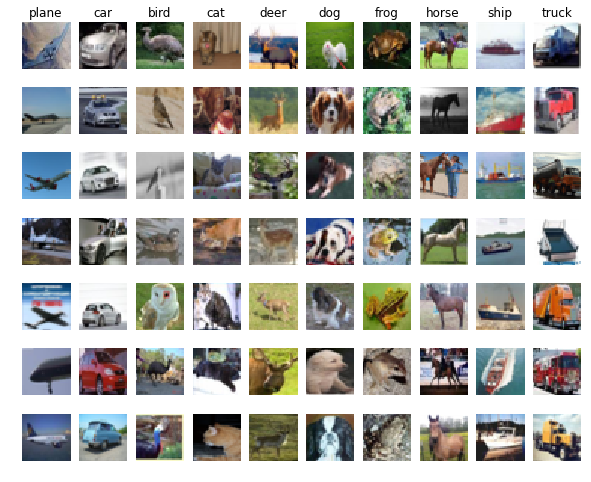

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise.
num_training = 49000
num_validation = 1000
num_test = 1000

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_training points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


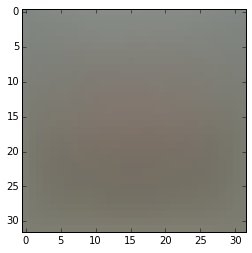

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
# Also, lets transform both data matrices so that each image is a column.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
# print X_train[0][-1]
print X_train.shape, X_val.shape, X_test.shape

(3073, 49000) (3073, 1000) (3073, 1000)


## SVM Classifier
Code for this section will all be written inside `f15ece6504/classifiers/linear_svm.py`.

In [9]:
from f15ece6504.classifiers.linear_svm import svm_loss_vectorized
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(10,3073) * 0.0001 

# Implement a vectorized code to implement the loss and the gradient of the SVM. 
# Remember that your code should not have any loops. 
# Hint: 
# Look up the broadcasting property of np arrays
# In case you have memory errors, you might want to use float16 or pickle your data
# check np.ndarray.dump()/load() if you consider pickling your data
                    
tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# It should be quite fast and finish within a second if your code is optimized! 

Vectorized loss and gradient: computed in 0.000172s


## Stochastic Gradient Descent (SGD)
Code for this section will be written in `f15ece6504/classifiers/linear_classifier.py`

In [10]:
# Now that we have efficient implementations for computing loss and gradients, let us use SGD to minimize 
# loss funtion

In [11]:
# Now implement SGD in LinearSVM.train() function and run it with the code below
from f15ece6504.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

float64


NameError: global name 'X_batch' is not defined

In [ ]:
# A useful debugging strategy is to plot the training loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

## Tuning the parameters
In our classifier, the learning rate and the regularization strength are hyper-parameters. Tuning them to appropriate values is needed to bring out the best from these classifiers. Generally, this takes experience and is generally considered a dark art! Spearmint is a software package which does this using Bayesian Optimization.

Assuming you have installed spearmint as mentioned in the README, we proceed to its set-up and usage. Spearmint needs you to create two files:
1. A wrapper file that calls the classifier, trains it and returns the error on the validation set
2. A config file that has details about the parameters to be tuned, language, etc. 
In you Spearmint installation directory, you have many examples that should give you an idea. 

You are provided with these two files in the `hw0/` directory. Complete them appropriately (depending on the classifier you use) and proceed to tuning your model. 

```sh
$ mongod --fork --logpath <path/to/logfile\> --dbpath <path/to/dbfolder\>
$ python /path/to/spearmint_install/spearmint/main.py </path/to/hw0\>
```

You may need to make a directory i.e. `dbfolder` before running the above commands. 

Once you tune the model, use these parameters to retrain the classifier (modify and run the first cell in the SGD section and proceed to the next). Spearmint saves the output of each iteration in `hw0/output`

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])